## FC Sentiment

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data PE

In [3]:
df = pd.read_csv("new_data/kitabisa_FC_sentiment.csv")
df.head()

content sentiment
0  Alhamdulillah sangat sangat membantu. Seneng b...  negative
1  Mohon maaf kok donasi yg terkumpul sampai ratu...  negative
2  Saya ingin bertanya  bagaimana cara saya menge...  negative
3  Sebelum ini aplikasi berjalan lancar  tapi ken...  negative
4  Sebelumnya saya berterimakasih byk dgn app ini...  negative

In [4]:
df.sentiment.value_counts()

negative    973
positive    236
Name: sentiment, dtype: int64

In [5]:
df.sentiment.value_counts(normalize=True)

negative    0.804797
positive    0.195203
Name: sentiment, dtype: float64

### Encoding with W2V Model

In [6]:
from gensim.models import Word2Vec

In [7]:
w2v = Word2Vec.load("model/w2v/kitabisa_review.w2v").wv

In [8]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    
    
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [9]:
vecs.shape

(1209, 200)

### Dataset Splitting

In [10]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((967, 200), (242, 200), (967,), (242,))

### SMOTE Data Modeling

In [11]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [12]:
print(Counter(y))

Counter({'negative': 973, 'positive': 236})


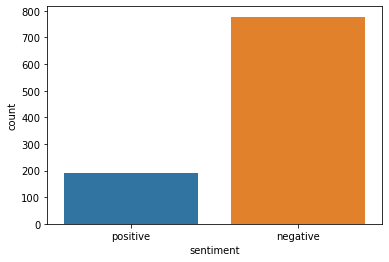

In [13]:
sns.countplot(x=y_train)

Text(0, 0.5, 'X column negatif')

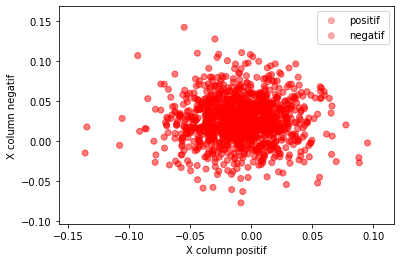

In [14]:
import matplotlib.pyplot as plt

for i, color in enumerate(['positif', 'negatif']):
    plt.scatter(X[:, 0], X[:, 1], c=['b' if p == i else 'r' for p in y], alpha=0.3, label=color)
plt.legend()
plt.xlabel('X column positif')
plt.ylabel('X column negatif')

In [15]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({'negative': 778, 'positive': 189})
Resample dataset shape is  Counter({'positive': 778, 'negative': 778})
Resample dataset test shape is  Counter({'negative': 195, 'positive': 195})


In [16]:
print(Counter(y_res))

Counter({'positive': 778, 'negative': 778})


### Training SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [19]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
{'algo__C': 10.0, 'algo__gamma': 10.0}
1.0 0.9691792398384038 0.8025641025641026


### Evaluation

In [20]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

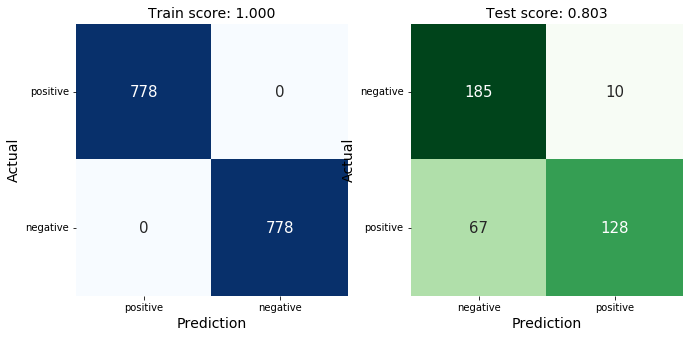

In [21]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [22]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       778
    positive       1.00      1.00      1.00       778

    accuracy                           1.00      1556
   macro avg       1.00      1.00      1.00      1556
weighted avg       1.00      1.00      1.00      1556


Test report
              precision    recall  f1-score   support

    negative       0.73      0.95      0.83       195
    positive       0.93      0.66      0.77       195

    accuracy                           0.80       390
   macro avg       0.83      0.80      0.80       390
weighted avg       0.83      0.80      0.80       390



### Encoding with FastText

In [23]:
from gensim.models import FastText

In [24]:
fastText = FastText.load("model/fasttext/kitabisa_review.fasttext").wv

In [25]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, fastText, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [26]:
vecs.shape

(1209, 200)

### Dataset Splitting

In [27]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((967, 200), (242, 200), (967,), (242,))

### SMOTE Data Modeling

In [28]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_test, y_res_test = sm.fit_resample(X_test, y_test)



print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))
print('Resample dataset test shape is ', Counter(y_res_test))

Original dataset shape is  Counter({'negative': 778, 'positive': 189})
Resample dataset shape is  Counter({'positive': 778, 'negative': 778})
Resample dataset test shape is  Counter({'negative': 195, 'positive': 195})


### Training with SVM

In [29]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_res, y_res)

print(model.best_params_)
print(model.score(X_res, y_res), model.best_score_, model.score(X_res_test, y_res_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
{'algo__C': 10.0, 'algo__gamma': 10.0}
1.0 0.968527908318905 0.7923076923076923


### Evaluation

In [30]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

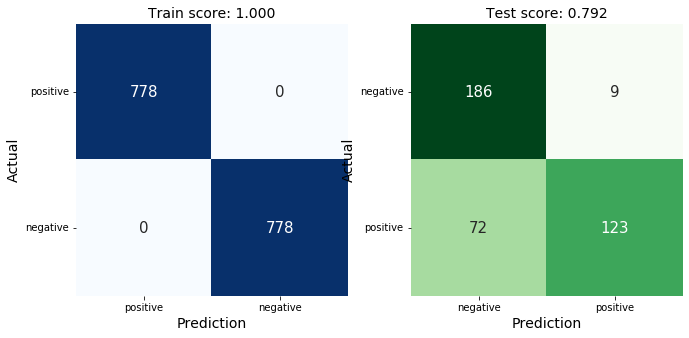

In [31]:
plot_confusion_matrix(X_res, y_res, X_res_test, y_res_test, model)

In [32]:
plot_classification_report(X_res, y_res, X_res_test, y_res_test, model, report=True)

Train report
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       778
    positive       1.00      1.00      1.00       778

    accuracy                           1.00      1556
   macro avg       1.00      1.00      1.00      1556
weighted avg       1.00      1.00      1.00      1556


Test report
              precision    recall  f1-score   support

    negative       0.72      0.95      0.82       195
    positive       0.93      0.63      0.75       195

    accuracy                           0.79       390
   macro avg       0.83      0.79      0.79       390
weighted avg       0.83      0.79      0.79       390

